# Object detection with **DETR (Detection Transformer)**

**Author: Marko Mirkovic**

Description: This notebook explores the implementation (with Tensorflow) and application of DETR (Detection Transformer).

It covers:
*   Imports and constants
*   Data preprocessing
*   Model architecture
*   Loss function
*   Training
*   Inference.

Car object detection, Source: (https://www.kaggle.com/datasets/sshikamaru/car-object-detection/data):
*   Small image dataset (around 1000 training instances) that's derived from videos of traffic.
*   It only contains one class (Car).
*   Annotations include object bounding boxes for each image.
*   It has been manualy converted to TF format of dataset.





---



# 1. Imports and constants

Import necessary libraries for building and training the DETR model,
handling datasets and annotations, performing numerical computations,
 and visualizing images with bounding boxes.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os

Configuration and hyperparameters for training the DETR model:
* IMAGE_SIZE, BATCH_SIZE: Define input image dimensions and batch size.
* NUM_CLASSES: Number of object classes (including "no object").
*  NUM_QUERIES: Number of object queries used by DETR.
* HIDDEN_DIM, N_HEADS, NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS: Transformer architecture parameters.
* EPOCHS, LEARNING_RATE, WEIGHT_DECAY: Training schedule and optimizer hyperparameters.


In [ ]:
DATA_DIR = "your-data-dir"
IMAGE_SIZE = (384, 672) # original is 676x380, but we are resizing to power of 32 because resnet downsamples by 32 so we avoid unnececery padding compute.
BATCH_SIZE = 2
NUM_CLASSES = 2
NUM_QUERIES = 50
HIDDEN_DIM = 256  # Dimension of the transformer embeddings
N_HEADS = 8       # Number of attention heads
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6

EPOCHS = 100
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4

# 2. Data Preprocessing




Utility function to preprocess and format dataset annotations for DETR.
* Converts bounding boxes from [xmin, ymin, xmax, ymax] to normalized [cx, cy, w, h] format.
* Pads both labels and boxes so each image has a fixed number of queries (NUM_QUERIES),
*   using -1 for "no object" labels and 0.0 for empty boxes.
* This ensures consistent tensor shapes for batching and training.

In [ ]:
def format_annotations(labels, boxes, img_shape, num_queries=NUM_QUERIES):
    labels = tf.cast(labels, dtype=tf.int32)
    height, width, _ = tf.unstack(tf.cast(img_shape, dtype=tf.float32))

    # Format from CSV: [xmin, ymin, xmax, ymax]
    xmin, ymin, xmax, ymax = tf.unstack(boxes, axis=-1)

    # Convert to [cx, cy, w, h] normalized
    cx = (xmin + xmax) / 2.0 / width
    cy = (ymin + ymax) / 2.0 / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height

    boxes = tf.stack([cx, cy, w, h], axis=-1)

    # Pad to NUM_QUERIES
    num_objects = tf.shape(boxes)[0]
    padding_count = num_queries - num_objects

    padded_boxes = tf.pad(boxes, [[0, padding_count], [0, 0]], constant_values=0.0)
    padded_labels = tf.pad(labels, [[0, padding_count]], constant_values=-1)

    return padded_labels, padded_boxes

Loads and preprocesses the dataset for DETR training.
* Reads annotations from CSV file.
* Splits dataset to train and val.
* Builds a consistent class-to-ID mapping for labels.
* Groups annotations by image and constructs lists of image paths, labels, and bounding boxes.
* Creates TensorFlow datasets for images, labels, and boxes.
* Applies preprocessing: image resizing/normalization and annotation formatting ([cx, cy, w, h] with padding).
* Shuffles and batches the training set, and prefetches all splits for efficient loading.


In [ ]:
def load_dataset(data_dir, batch_size=BATCH_SIZE, num_queries=NUM_QUERIES, val_split=0.15):
    datasets = {}

    all_annotations_df = pd.read_csv(os.path.join(data_dir, 'train', '_annotations.csv'))
    all_annotations_df.dropna(inplace=True)

    class_names = all_annotations_df['class'].unique()
    class_to_id = {name: i for i, name in enumerate(class_names)}
    print(f"Class mapping created: {class_to_id}")

    filenames = all_annotations_df['filename'].unique()
    np.random.shuffle(filenames)

    val_size = int(len(filenames) * val_split)
    val_files = set(filenames[:val_size])
    train_files = set(filenames[val_size:])

    # Helper function to build dataset for a set of files
    def build_split(file_set):
        image_paths, all_labels, all_boxes = [], [], []

        for filename, group in all_annotations_df.groupby("filename"):
            if filename not in file_set:
                continue
            image_paths.append(os.path.join(data_dir, 'train', filename))
            labels = [class_to_id[name] for name in group["class"]]
            all_labels.append(labels)
            boxes = group[["xmin", "ymin", "xmax", "ymax"]].values
            all_boxes.append(boxes)

        path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
        label_ds = tf.data.Dataset.from_generator(
            lambda: all_labels,
            output_signature=tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )
        box_ds = tf.data.Dataset.from_generator(
            lambda: all_boxes,
            output_signature=tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
        )

        image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = tf.data.Dataset.zip((image_ds, label_ds, box_ds))

        def _format_sample(image, labels, boxes):
            labels, boxes = format_annotations(labels, boxes, tf.shape(image), num_queries)
            return image, labels, boxes

        dataset = dataset.map(_format_sample, num_parallel_calls=tf.data.AUTOTUNE)
        return dataset

    # Build train + val
    train_dataset = build_split(train_files).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = build_split(val_files).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    datasets["train"] = train_dataset
    datasets["val"] = val_dataset

    return datasets, class_to_id

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0
    return image


datasets, class_mapping = load_dataset(DATA_DIR, batch_size=BATCH_SIZE)


Class mapping created: {'Car': 0}


Random data augmentation methods for increasing generalization of the model.

In [ ]:
def random_brightness_contrast(image, boxes):
    """Random brightness and contrast."""
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, boxes

def augment_image(image, labels, boxes):
    """Applies augmentation to image and boxes, keeping labels aligned."""
    image, boxes = random_brightness_contrast(image, boxes)
    return image, labels, boxes

Testing if we get proper shape of images.

In [ ]:
train_dataset = datasets["train"]
train_dataset = train_dataset.map(
    lambda img, lbls, bxs: augment_image(img, lbls, bxs),
    num_parallel_calls=tf.data.AUTOTUNE
)
for image, _,_ in train_dataset.take(1):
  print(image.shape)

(2, 384, 672, 3)


# 3. Model Architecture


Defines the feature extractor (backbone) for DETR.
* Uses a ResNet-50 pretrained on ImageNet as the backbone.
* Excludes the top (classification) layers since we only need convolutional features.
* Outputs the feature map from the last block of the 4th stage ('conv4_block6_out'), which has a good balance of spatial resolution and semantic richness.
* Wraps the backbone into a tf.keras.Model that outputs this feature map given an input image.


In [ ]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    )
    feature_map_output = backbone.get_layer('conv4_block6_out').output
    model = tf.keras.Model(inputs=backbone.input, outputs=feature_map_output)
    return model


Generates 2D sinusoidal positional encodings for transformer input.
* Provides a unique positional signal for each spatial location in the feature map.
* Works for dynamic image shapes (height and width can be tensors).
* Uses sine and cosine functions with varying frequencies (similar to the original Transformer paper) to encode both row (y) and column (x) positions.
* The resulting tensor has shape (height, width, dim) and is added to the CNN feature map to inject spatial information into the transformer.


In [ ]:
def positional_encoding(height, width, dim):
    assert dim % 4 == 0, "Hidden dimension must be divisible by 4"

    # Create grid of positions
    y = tf.range(height)   # shape (H,)
    x = tf.range(width)    # shape (W,)
    y, x = tf.meshgrid(y, x, indexing="ij")  # shapes (H, W)

    # Compute frequencies
    dim_t = tf.range(dim // 2, dtype=tf.float32)
    inv_freq = 1.0 / (10000.0 ** (dim_t / (dim // 2)))

    # Expand positions for broadcasting
    y = tf.cast(tf.expand_dims(y, -1), tf.float32) * inv_freq   # (H, W, dim//2)
    x = tf.cast(tf.expand_dims(x, -1), tf.float32) * inv_freq   # (H, W, dim//2)

    # Encode with sine and cosine
    pos_y = tf.concat([tf.sin(y[..., :dim // 4]), tf.cos(y[..., :dim // 4])], axis=-1)
    pos_x = tf.concat([tf.sin(x[..., :dim // 4]), tf.cos(x[..., :dim // 4])], axis=-1)

    # Final encoding: (H, W, dim)
    pos = tf.concat([pos_y, pos_x], axis=-1)
    return pos


Single Transformer encoder layer used in DETR.
* Implements one layer of the standard transformer encoder: Multi-Head Self-Attention (MHA) + Feed-Forward Network (FFN).
* Layer normalization and residual connections are applied after both MHA and FFN for stability.
* Dropout is applied after attention and FFN to prevent overfitting.
* Input `x` should have shape (batch_size, sequence_length, hidden_dim), e.g., flattened CNN feature map + positional encoding.
* Output has the same shape as input, ready to be fed to the next encoder layer or decoder.


In [ ]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, n_heads, dropout=0.1):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=n_heads, key_dim=hidden_dim, dropout=dropout
        )
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim * 4, activation="relu"),
            tf.keras.layers.Dense(hidden_dim),
        ])
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, x, training=False):
        attn_output = self.mha(x, x, x, training=training)
        x = self.norm1(x + self.dropout1(attn_output, training=training))

        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output, training=training))
        return x


Single Transformer decoder layer used in DETR.

* Implements one decoder layer:
*   1) Self-attention on the decoder queries,
*   2) Cross-attention where queries attend to the encoder output (memory),
*   3) Feed-Forward Network (FFN).
* Each sublayer has residual connections, layer normalization, and dropout for stability and regularization.
* Input `x` represents the query embeddings (object queries), `memory` is the encoder output.
* Output has the same shape as the queries, ready to be fed to the next decoder layer or to prediction heads.


In [ ]:
class TransformerDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, n_heads, dropout=0.1):
        super().__init__()
        self.self_mha = tf.keras.layers.MultiHeadAttention(
            num_heads=n_heads, key_dim=hidden_dim, dropout=dropout
        )
        self.cross_mha = tf.keras.layers.MultiHeadAttention(
            num_heads=n_heads, key_dim=hidden_dim, dropout=dropout
        )
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim * 4, activation="relu"),
            tf.keras.layers.Dense(hidden_dim),
        ])
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)
        self.dropout3 = tf.keras.layers.Dropout(dropout)

    def call(self, x, memory, training=False):
        self_attn = self.self_mha(x, x, x, training=training)
        x = self.norm1(x + self.dropout1(self_attn, training=training))

        cross_attn = self.cross_mha(x, memory, memory, training=training)
        x = self.norm2(x + self.dropout2(cross_attn, training=training))

        ffn_output = self.ffn(x)
        x = self.norm3(x + self.dropout3(ffn_output, training=training))
        return x


Full Transformer block for DETR.

* Composes multiple encoder and decoder layers into a complete Transformer.
* Encoder:
*   - Flattens the CNN feature map into a sequence.
*   - Adds positional embeddings to retain spatial information.
*   - Passes through a stack of TransformerEncoderLayers.
* Decoder:
*   - Uses object queries (learnable embeddings) expanded to batch size.
*   - Passes through a stack of TransformerDecoderLayers attending to encoder memory.
* Output: processed query embeddings, ready for classification and bounding box prediction heads.


In [ ]:
class Transformer(tf.keras.layers.Layer):
    def __init__(self, num_encoder_layers, num_decoder_layers, hidden_dim, n_heads, dropout=0.1):
        super().__init__()
        self.encoder_layers = [
            TransformerEncoderLayer(hidden_dim, n_heads, dropout)
            for _ in range(num_encoder_layers)
        ]
        self.decoder_layers = [
            TransformerDecoderLayer(hidden_dim, n_heads, dropout)
            for _ in range(num_decoder_layers)
        ]

    def call(self, src, pos_embed, query_embed, training=False):
        # Flatten input: (batch, h, w, c) -> (batch, h*w, c)
        bs = tf.shape(src)[0]
        h = tf.shape(src)[1]
        w = tf.shape(src)[2]
        c = tf.shape(src)[3]

        src_flat = tf.reshape(src, (bs, h * w, c))
        pos_embed_flat = tf.reshape(pos_embed, (bs, h * w, c))

        memory = src_flat + pos_embed_flat

        for layer in self.encoder_layers:
            memory = layer(memory, training=training)

        # Prepare query embeddings (num_queries, dim) -> (batch, num_queries, dim)
        query_embed = tf.expand_dims(query_embed, axis=0)
        target = tf.tile(query_embed, [bs, 1, 1])

        output = target
        for layer in self.decoder_layers:
            output = layer(output, memory, training=training)

        return output


DETR Model Definition
* Wraps the full DETR pipeline in a tf.keras.Model.
* Backbone: ResNet-50 pretrained on ImageNet to extract CNN feature maps.
* Input projection: 1x1 convolution to match the Transformer hidden dimension.
* Transformer: encoder-decoder stack processes flattened feature maps with object queries.
* Positional encoding: 2D sinusoidal encodings added to feature maps for spatial awareness.
* Object queries: learnable embeddings representing potential object detections.
* Prediction heads:
*   - class_embed: outputs logits for each query (num_classes + 1 for "no object").
*   - bbox_embed: outputs 4 normalized bounding box coordinates per query.
* call(): performs forward pass producing predicted class logits and bounding boxes.


In [ ]:
class DETR(tf.keras.Model):
    def __init__(self, num_classes, hidden_dim, n_heads, num_encoder_layers, num_decoder_layers):
        super().__init__()
        self.backbone = get_backbone()

        # 1x1 convolution to reduce feature map channels
        self.input_proj = tf.keras.layers.Conv2D(hidden_dim, kernel_size=1)

        self.transformer = Transformer(num_encoder_layers, num_decoder_layers, hidden_dim, n_heads)

        self.pos_encoding_gen = positional_encoding

        self.class_embed = tf.keras.layers.Dense(num_classes + 1, name='class_head')
        self.bbox_embed = tf.keras.layers.Dense(4, name='bbox_head')

        self.query_embed = tf.Variable(
            tf.random.uniform(shape=(NUM_QUERIES, hidden_dim)),
            trainable=True,
            name="query_embeddings"
        )
        self.hidden_dim = hidden_dim

    def call(self, inputs):
        # 1. Feature extraction
        features = self.backbone(inputs)
        features = self.input_proj(features)

        # 2. Positional encoding
        h = tf.shape(features)[1]
        w = tf.shape(features)[2]
        pos_embed = self.pos_encoding_gen(h, w, self.hidden_dim)
        pos_embed = tf.expand_dims(pos_embed, axis=0)
        pos_embed = tf.tile(pos_embed, [tf.shape(inputs)[0], 1, 1, 1])

        # 3. Transformer
        transformer_output = self.transformer(features, pos_embed, self.query_embed)

        # 4. Prediction
        class_logits = self.class_embed(transformer_output)
        # Use sigmoid to ensure box coordinates are in [0, 1] range after normalization
        pred_boxes = tf.keras.activations.sigmoid(self.bbox_embed(transformer_output))

        return {'pred_logits': class_logits, 'pred_boxes': pred_boxes}


# 4. Loss function

Hungarian Matching Utility
* Uses the Hungarian (linear sum) algorithm for optimal bipartite matching.
* Used in DETR to match predicted object queries with ground-truth objects.
* _numpy_matching: wraps SciPy's linear_sum_assignment to compute minimal-cost assignment.
* tf.py_function: allows using the NumPy/SciPy function within TensorFlow's graph execution.
* Returns two integer arrays: indices of matched predictions and ground-truths.


Generalized IoU (GIoU) Computation
* Computes the Generalized Intersection over Union between two sets of bounding boxes.
* Converts boxes from center format [cx, cy, w, h] to corner format [x1, y1, x2, y2].
* Calculates:
*   1. Intersection area
*   2. Union area
*   3. Standard IoU
*   4. Enclosing box area to compute GIoU
* Returns a tensor representing the GIoU, which penalizes both overlap and distance between boxes.
* Used in DETR as part of the bounding box regression loss.


In [ ]:
def bbox_giou(box1, box2):
    # Convert from [cx, cy, w, h] to [x1, y1, x2, y2]
    box1_x1 = box1[..., 0] - box1[..., 2] / 2
    box1_y1 = box1[..., 1] - box1[..., 3] / 2
    box1_x2 = box1[..., 0] + box1[..., 2] / 2
    box1_y2 = box1[..., 1] + box1[..., 3] / 2

    box2_x1 = box2[..., 0] - box2[..., 2] / 2
    box2_y1 = box2[..., 1] - box2[..., 3] / 2
    box2_x2 = box2[..., 0] + box2[..., 2] / 2
    box2_y2 = box2[..., 1] + box2[..., 3] / 2

    # Intersection area
    inter_x1 = tf.maximum(box1_x1, box2_x1)
    inter_y1 = tf.maximum(box1_y1, box2_y1)
    inter_x2 = tf.minimum(box1_x2, box2_x2)
    inter_y2 = tf.minimum(box1_y2, box2_y2)
    inter_area = tf.maximum(0.0, inter_x2 - inter_x1) * tf.maximum(0.0, inter_y2 - inter_y1)

    # Union area
    area1 = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    area2 = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = area1 + area2 - inter_area

    iou = inter_area / (union_area + 1e-6)

    # Enclosing box
    enclose_x1 = tf.minimum(box1_x1, box2_x1)
    enclose_y1 = tf.minimum(box1_y1, box2_y1)
    enclose_x2 = tf.maximum(box1_x2, box2_x2)
    enclose_y2 = tf.maximum(box1_y2, box2_y2)
    enclose_area = (enclose_x2 - enclose_x1) * (enclose_y2 - enclose_y1)

    giou = iou - (enclose_area - union_area) / (enclose_area + 1e-6)
    return giou

DETR Loss Class
* Implements the custom loss function for DETR, combining classification and bounding box regression.
* 1. Sparse categorical cross-entropy for object classification, including "no object" handling.
* 2. Bounding box regression using:
*  - L1 loss between predicted and target boxes
*  - Generalized IoU (GIoU) loss
* 3. Hungarian matching to optimally assign predicted queries to ground-truth objects per sample.
* Handles padded sequences in DETR by masking padded labels (-1).
* Computes per-sample losses with tf.map_fn and averages over the batch.


In [ ]:
from scipy.optimize import linear_sum_assignment

class DETRLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes, num_queries, no_object_weight=0.1, giou_weight=2.0, l1_weight=5.0):
        super().__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        self.no_object_weight = no_object_weight
        self.giou_weight = giou_weight
        self.l1_weight = l1_weight
        self.ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    def _hungarian_match(self, cost_matrix):
        """Run Hungarian matching via SciPy inside tf.py_function."""
        def match_numpy(cost):
            pred_idx, true_idx = linear_sum_assignment(cost)
            return np.array(pred_idx, dtype=np.int32), np.array(true_idx, dtype=np.int32)

        pred_idx, true_idx = tf.py_function(func=match_numpy,
                                            inp=[cost_matrix],
                                            Tout=[tf.int32, tf.int32])
        pred_idx.set_shape([None])
        true_idx.set_shape([None])
        return pred_idx, true_idx

    def _per_sample_loss(self, inputs):
        y_true_labels, y_true_boxes, y_pred_logits, y_pred_boxes = inputs

        # Mask padded ground truth
        mask = tf.cast(y_true_labels != -1, tf.bool)
        true_labels = tf.boolean_mask(y_true_labels, mask)
        true_boxes = tf.boolean_mask(y_true_boxes, mask)

        pred_logits = y_pred_logits
        pred_boxes = y_pred_boxes

        if tf.shape(true_labels)[0] == 0:
            # No object in this sample, only compute "no object" loss
            target_labels = tf.fill([self.num_queries], self.num_classes - 1)
            class_loss = self.ce_loss(target_labels, pred_logits)
            weights = tf.where(target_labels == self.num_classes - 1, self.no_object_weight, 1.0)
            return tf.reduce_sum(class_loss * weights) / tf.reduce_sum(weights)

        # Cost matrix for Hungarian matching
        cost_class = -tf.gather(tf.nn.softmax(pred_logits, axis=-1), true_labels, axis=1)
        cost_l1 = tf.reduce_sum(tf.abs(pred_boxes[:, None] - true_boxes[None, :]), axis=-1)
        cost_giou = -bbox_giou(pred_boxes[:, None], true_boxes[None, :])
        cost_matrix = self.l1_weight * cost_l1 + self.giou_weight * cost_giou + cost_class

        # Hungarian matching
        pred_idx, true_idx = self._hungarian_match(cost_matrix)

        # Classification target
        target_labels = tf.fill([self.num_queries], self.num_classes - 1)
        target_labels = tf.tensor_scatter_nd_update(target_labels,
                                                    tf.expand_dims(pred_idx, axis=1),
                                                    tf.gather(true_labels, true_idx))

        # Classification loss
        class_loss = self.ce_loss(target_labels, pred_logits)
        weights = tf.where(target_labels == self.num_classes - 1, self.no_object_weight, 1.0)
        class_loss = tf.reduce_sum(class_loss * weights) / tf.reduce_sum(weights)

        # BBox loss
        matched_pred_boxes = tf.gather(pred_boxes, pred_idx)
        matched_true_boxes = tf.gather(true_boxes, true_idx)
        loss_l1 = tf.reduce_mean(tf.abs(matched_pred_boxes - matched_true_boxes))
        loss_giou = 1 - tf.reduce_mean(bbox_giou(matched_pred_boxes, matched_true_boxes))
        total_box_loss = self.l1_weight * loss_l1 + self.giou_weight * loss_giou

        return class_loss + total_box_loss

    def compute_loss(self, y_true_labels, y_true_boxes, y_pred_logits, y_pred_boxes):
        # Use tf.map_fn to compute per-sample loss
        batch_losses = tf.map_fn(
            self._per_sample_loss,
            (y_true_labels, y_true_boxes, y_pred_logits, y_pred_boxes),
            dtype=tf.float32
        )
        return tf.reduce_mean(batch_losses)


# 5. Training

Model, Loss, Optimizer, and Dataset Setup

* Initializes the DETR model with specified hyperparameters
* Creates the DETRLoss instance
* Sets up the AdamW optimizer with learning rate and weight decay for training stability.
* Prepares the datasets:
*   - Training dataset includes data augmentation applied on-the-fly.
*   - Validation dataset remains unaltered to fairly evaluate model performance.
* This setup ensures the model, loss, optimizer, and data pipelines are ready for the training loop.


In [ ]:
detr_model = DETR(
    num_classes=NUM_CLASSES,
    hidden_dim=HIDDEN_DIM,
    n_heads=N_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS
)

loss_fn = DETRLoss(num_classes=NUM_CLASSES, num_queries=NUM_QUERIES)
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

train_dataset = datasets["train"]
val_dataset = datasets["val"]
train_dataset = train_dataset.map(
    lambda img, lbls, bxs: augment_image(img, lbls, bxs),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [ ]:
detr_model.summary()

Model: "detr_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_13 (Functional)      │ (None, 24, 42, 1024)   │     8,589,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_1 (Transformer)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_head (Dense)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bbox_head (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,589,184 (32.77 MB)

 Trainable params: 8,558,592 (32.65 MB)

 Non-trainable params: 30,592 (119.50 KB)

Single Training Step

* Performs one forward and backward pass for a batch of images.
* Computes model predictions (class logits and bounding boxes).
* Calculates the DETR loss.
* Computes gradients with respect to model parameters.
* Applies gradient clipping to prevent exploding gradients (max norm 0.1).
* Updates model weights using the AdamW optimizer.
* Returns the scalar loss for logging and monitoring training progress.


In [ ]:
@tf.function
def train_step(images, true_labels, true_boxes):
    with tf.GradientTape() as tape:
        predictions = detr_model(images, training=True)
        pred_logits = predictions['pred_logits']
        pred_boxes = predictions['pred_boxes']

        loss = loss_fn.compute_loss(true_labels, true_boxes, pred_logits, pred_boxes)

    gradients = tape.gradient(loss, detr_model.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 0.1)
    optimizer.apply_gradients(zip(gradients, detr_model.trainable_variables))
    return loss


Single Validation Step

* Performs a forward pass on a batch of validation images without updating model weights.
* Computes the model's predictions (class logits and bounding boxes).
* Calculates the DETR loss for the batch using the same loss function as training.
* Returns the scalar loss, which can be used to monitor validation performance.


In [ ]:
@tf.function
def val_step(images, labels, boxes):
    preds = detr_model(images, training=False)
    return loss_fn.compute_loss(labels, boxes, preds['pred_logits'], preds['pred_boxes'])

Training and Validation Loop with Loss Logging
* Iterates over a fixed number of epochs for training the DETR model.
* Training loop:
*   - Iterates over batches from the training dataset.
*   - Performs a gradient update using `train_step`.
*   - Accumulates batch losses and computes average training loss per epoch.
*   - Stores training loss in `train_losses` for later visualization.
* Validation loop:
*   - Iterates over batches from the validation dataset.
*   - Computes loss using `val_step` without updating weights.
*   - Accumulates and averages validation loss per epoch.
*   - Stores validation loss in `val_losses` for monitoring overfitting and performance.


In [ ]:
train_losses = []
val_losses = []

In [ ]:
for epoch in range(EPOCHS):
    # Training loop
    total_loss = 0
    num_batches = 0
    for images, labels, boxes in train_dataset:
        loss = train_step(images, labels, boxes)
        total_loss += loss
        num_batches += 1
    avg_train_loss = total_loss / num_batches
    train_losses.append(avg_train_loss.numpy())
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}")

    # Validation loop
    val_loss = 0
    val_batches = 0
    for images, labels, boxes in val_dataset:
        batch_loss = val_step(images, labels, boxes)
        val_loss += batch_loss
        val_batches += 1
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss.numpy())
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")
    if epoch != 0 and epoch % 25 == 0:
      detr_model.save_weights(f"/content/drive/MyDrive/Colab Notebooks/DL(PMF)/model/detr_{100 + epoch}.weights.h5")



Epoch 1 - Train Loss: 1.5106
Epoch 1 - Validation Loss: 1.3937
Epoch 2 - Train Loss: 1.5264
Epoch 2 - Validation Loss: 1.5729
Epoch 3 - Train Loss: 1.4702
Epoch 3 - Validation Loss: 1.4991
Epoch 4 - Train Loss: 1.5156
Epoch 4 - Validation Loss: 1.5650
Epoch 5 - Train Loss: 1.5218
Epoch 5 - Validation Loss: 1.4051
Epoch 6 - Train Loss: 1.5428
Epoch 6 - Validation Loss: 1.6432
Epoch 7 - Train Loss: 1.5389
Epoch 7 - Validation Loss: 1.8437
Epoch 8 - Train Loss: 1.5466
Epoch 8 - Validation Loss: 1.3695
Epoch 9 - Train Loss: 1.4897
Epoch 9 - Validation Loss: 1.3988
Epoch 10 - Train Loss: 1.5394
Epoch 10 - Validation Loss: 1.7417
Epoch 11 - Train Loss: 1.4585
Epoch 11 - Validation Loss: 1.8777
Epoch 12 - Train Loss: 1.4929
Epoch 12 - Validation Loss: 1.7856
Epoch 13 - Train Loss: 1.5361
Epoch 13 - Validation Loss: 1.3206
Epoch 14 - Train Loss: 1.4648
Epoch 14 - Validation Loss: 1.4433
Epoch 15 - Train Loss: 1.4779
Epoch 15 - Validation Loss: 1.3772
Epoch 16 - Train Loss: 1.4307
Epoch 16 - Va

In [ ]:
detr_model.save_weights("/content/drive/MyDrive/Colab Notebooks/DL(PMF)/model/detr_200.weights.h5")

Model was trained for 204 epochs, 4 epochs while testing (forgot to reset the model weights, and then twice for 100 epochs).

Plotting the losses

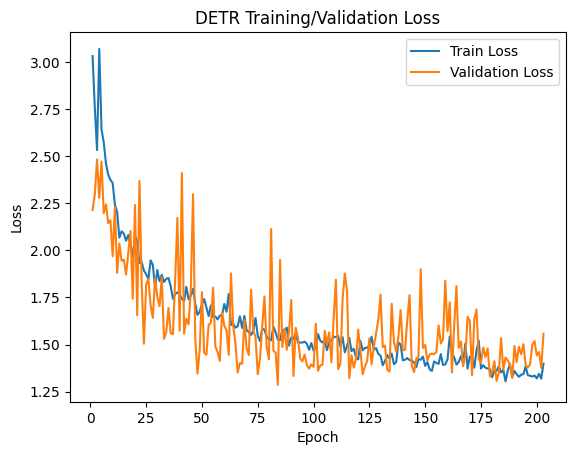

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DETR Training/Validation Loss')
plt.legend()
plt.show()


Here we can definetly see that validation loss is very noisy, probably because I used batch size of 2 (limitation due to GPU memory), also DETRs are specialy noisy and hard to stabilize and converge.

# 6. Inference



Utility to visualize random predictions from the model.
* Picks `num_samples` images from the dataset, runs the DETR model,
* filters predicted boxes by a confidence threshold, converts boxes to pixel coordinates,
* and plots them with bounding boxes and class labels.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def show_random_predictions(model, dataset, class_mapping, num_samples=5, threshold=0.5):
    # If class_mapping is already id -> name, don't invert
    id_to_class = {v: k for k, v in class_mapping.items()} if not all(isinstance(k, int) for k in class_mapping) else class_mapping

    # Collect images (for small datasets, this is fine)
    images_list = []
    for imgs, _, _ in dataset:
        for img in imgs:
            images_list.append(tf.clip_by_value(img, 0.0, 1.0).numpy())

    selected_imgs = random.sample(images_list, num_samples)

    for idx, img in enumerate(selected_imgs):
        input_image = tf.expand_dims(img, axis=0)  # Add batch dim
        preds = model(input_image, training=False)
        pred_logits = preds['pred_logits'][0]  # [num_queries, num_classes + 1]
        pred_boxes = preds['pred_boxes'][0]    # [num_queries, 4] in [cx,cy,w,h] normalized

        # Compute scores and filter by threshold (exclude "no object" class)
        probs = tf.nn.softmax(pred_logits, axis=-1)
        scores = tf.reduce_max(probs[:, :-1], axis=-1)  # exclude last class ("no object")
        keep = scores > threshold

        boxes = tf.boolean_mask(pred_boxes, keep)
        filtered_logits = tf.boolean_mask(pred_logits[:, :-1], keep)  # exclude "no object"
        labels = tf.argmax(filtered_logits, axis=-1)
        scores = tf.boolean_mask(scores, keep)

        # Convert boxes to [xmin, ymin, width, height] in pixels
        h, w, _ = img.shape
        boxes_px = tf.stack([
            (boxes[:,0] - boxes[:,2]/2) * w,
            (boxes[:,1] - boxes[:,3]/2) * h,
            boxes[:,2] * w,
            boxes[:,3] * h
        ], axis=-1)

        # Plot
        fig, ax = plt.subplots(1, figsize=(10,8))
        ax.imshow(img)
        for b, l, s in zip(boxes_px, labels, scores):
            rect = patches.Rectangle((b[0], b[1]), b[2], b[3],
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(b[0], b[1]-5, f"Car: {s.numpy():.2f}",
                    color='white', backgroundcolor='red', fontsize=10)
        plt.axis('off')
        plt.show()



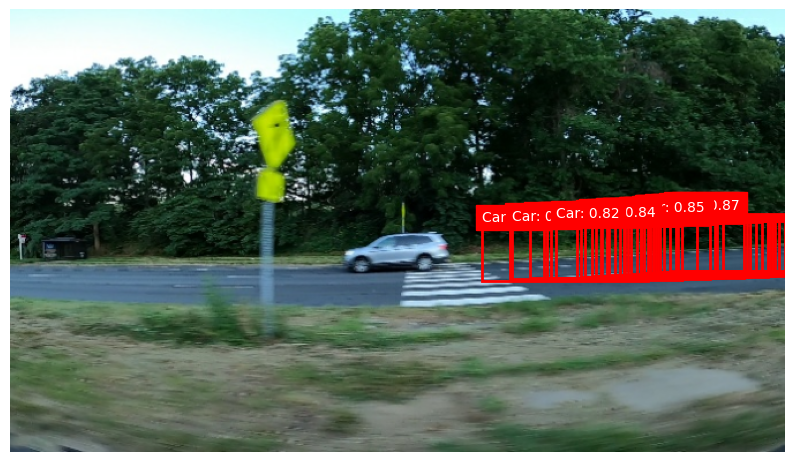

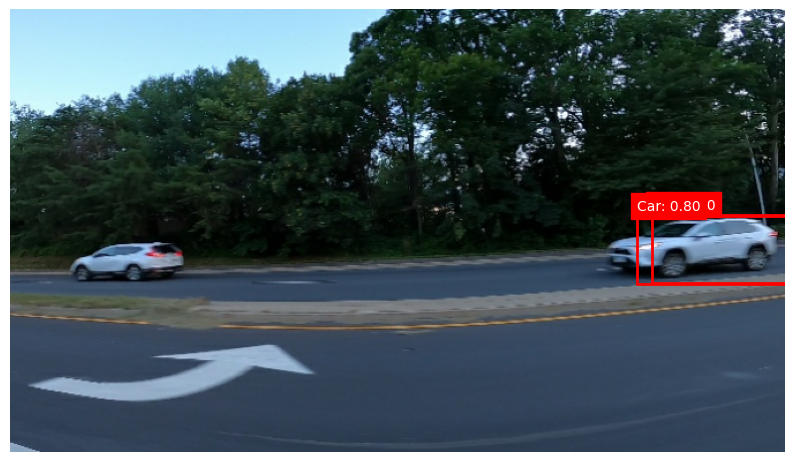

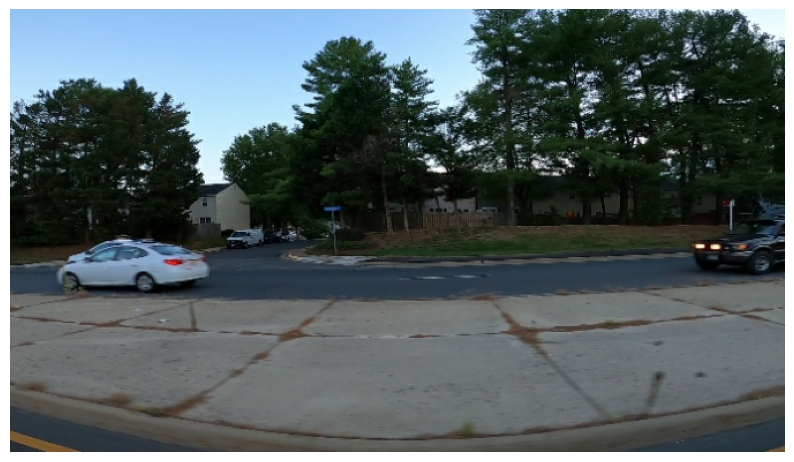

In [ ]:
show_random_predictions(detr_model, val_dataset, class_mapping, num_samples=3, threshold=0.8)

Some images like the first one have trailing bounding boxed, probably because dataset is from video and some images have car moving while the background is still, so the model does figure out where the car is moving, only has problem picking the exact spot. This shows that the model is learning but still needing more data.

Second image shows examples where the model did quite good with one car, but didn't get the other. Still showing good learning capabilities, only needing some improvements.

On the third image we didn't get any cars with this threshold.

Considering that DETR has transformer which is very data hungry architecture, and the other components that add complexity, that makes DETRs really data hungry, requiring loads of data and training resources. This project mainly shows their ability to learn, even on small dataset.